In [1]:
from sklearn.datasets import fetch_openml
import numpy as np
import pandas as pd
import seaborn as sns

#Common Model Algorithms
from sklearn import svm, tree, linear_model, neighbors, naive_bayes, ensemble, discriminant_analysis, gaussian_process

#Common Model Helpers
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn import feature_selection
from sklearn import model_selection
from sklearn import metrics

import matplotlib as mpl
import matplotlib.pyplot as plt

%matplotlib inline
# mpl.style.use('ggplot')
sns.set_style('white')

In [2]:
train_data_raw = pd.read_csv("inputs/train.csv")
test_data_raw = pd.read_csv("inputs/test.csv")
print(train_data_raw.info())
train_data_raw.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


In [3]:
print('Train columns with null values:\n', train_data_raw.isnull().sum())
print("-"*10)

print('Test/Validation columns with null values:\n', test_data_raw.isnull().sum())
print("-"*10)

train_data_raw.describe(include = 'all')

Train columns with null values:
 PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64
----------
Test/Validation columns with null values:
 PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64
----------


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
count,891.000000,891.000000,891.000000,891,891,714.000000,891.000000,891.000000,891,891.000000,204,889
unique,NaN,NaN,NaN,891,2,NaN,NaN,NaN,681,NaN,147,3
top,NaN,NaN,NaN,"Braund, Mr. Owen Harris",male,NaN,NaN,NaN,347082,NaN,B96 B98,S
freq,NaN,NaN,NaN,1,577,NaN,NaN,NaN,7,NaN,4,644
mean,446.000000,0.383838,2.308642,NaN,NaN,29.699118,0.523008,0.381594,NaN,32.204208,NaN,NaN
std,257.353842,0.486592,0.836071,NaN,NaN,14.526497,1.102743,0.806057,NaN,49.693429,NaN,NaN
min,1.000000,0.000000,1.000000,NaN,NaN,0.420000,0.000000,0.000000,NaN,0.000000,NaN,NaN
25%,223.500000,0.000000,2.000000,NaN,NaN,20.125000,0.000000,0.000000,NaN,7.910400,NaN,NaN
50%,446.000000,0.000000,3.000000,NaN,NaN,28.000000,0.000000,0.000000,NaN,14.454200,NaN,NaN
75%,668.500000,1.000000,3.000000,NaN,NaN,38.000000,1.000000,0.000000,NaN,31.000000,NaN,NaN


In [4]:

## Data Cleaning

def clean_data(data, drop_columns):
	df = data.copy(deep = True)

	# Use median age for missing age values
	df['Age'].fillna(df['Age'].median(), inplace = True)

	# Use mode for missing embarked values
	df['Embarked'].fillna(df['Embarked'].mode()[0], inplace = True)

	# Use median fare for missing fare values
	df['Fare'].fillna(df['Fare'].median(), inplace = True)

	# Drop columns that are not useful
	df.drop(drop_columns, axis = 1, inplace = True)
	
	return df

drop_columns = []
train_data = clean_data(train_data_raw, drop_columns)
test_data = clean_data(test_data_raw, drop_columns)

print(train_data.isnull().sum())
print("-"*10)
print(test_data.isnull().sum())

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         0
dtype: int64
----------
PassengerId      0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          327
Embarked         0
dtype: int64


In [5]:

## Feature Engineering

def feature_engineering(data):
	# Create new feature for family size
	data['FamilySize'] = data['SibSp'] + data['Parch'] + 1

	# Create new feature for is alone
	data['IsAlone'] = 1
	data.loc[data['FamilySize'] > 1, 'IsAlone'] = 0

	# Create new feature for title
	data['Title'] = data['Name'].str.split(", ", expand = True)[1].str.split(".", expand = True)[0]
	# Clean up the titles: replace rare titles with Misc
	stat_min = 10
	title_names = (data['Title'].value_counts() < stat_min)
	data['Title'] = data['Title'].apply(lambda x: 'Misc' if title_names.loc[x] == True else x)

	# Age*Class
	data['Age*Class'] = data['Age'] * data['Pclass']

	# Create new feature for age bin
	data['AgeBin'] = pd.cut(data['Age'].astype(int), 5)

	# Create new feature for fare bin
	data['FareBin'] = pd.qcut(data['Fare'], 4)

	# Create FarePerPerson
	data['FarePerPerson'] = data['Fare'] / data['FamilySize']

	# Create FarePerPersonBin
	data['FarePerPersonBin'] = pd.qcut(data['FarePerPerson'], 4)

	# HasCabin
	data['HasCabin'] = data['Cabin'].apply(lambda x: 0 if x is np.nan else 1)

	return data

train_data = feature_engineering(train_data)
test_data = feature_engineering(test_data)

# train_data['Title'].value_counts()
train_data.head(10)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,...,Embarked,FamilySize,IsAlone,Title,Age*Class,AgeBin,FareBin,FarePerPerson,FarePerPersonBin,HasCabin
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,...,S,2,0,Mr,66.0,"(16.0, 32.0]","(-0.001, 7.91]",3.62500,"(-0.001, 7.25]",0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,...,C,2,0,Mrs,38.0,"(32.0, 48.0]","(31.0, 512.329]",35.64165,"(23.667, 512.329]",1
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,...,S,1,1,Miss,78.0,"(16.0, 32.0]","(7.91, 14.454]",7.92500,"(7.25, 8.3]",0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,...,S,2,0,Mrs,35.0,"(32.0, 48.0]","(31.0, 512.329]",26.55000,"(23.667, 512.329]",1
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,...,S,1,1,Mr,105.0,"(32.0, 48.0]","(7.91, 14.454]",8.05000,"(7.25, 8.3]",0
5,6,0,3,"Moran, Mr. James",male,28.0,0,0,330877,8.4583,...,Q,1,1,Mr,84.0,"(16.0, 32.0]","(7.91, 14.454]",8.45830,"(8.3, 23.667]",0
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,...,S,1,1,Mr,54.0,"(48.0, 64.0]","(31.0, 512.329]",51.86250,"(23.667, 512.329]",1
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,...,S,5,0,Master,6.0,"(-0.08, 16.0]","(14.454, 31.0]",4.21500,"(-0.001, 7.25]",0
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,...,S,3,0,Mrs,81.0,"(16.0, 32.0]","(7.91, 14.454]",3.71110,"(-0.001, 7.25]",0
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,...,C,2,0,Mrs,28.0,"(-0.08, 16.0]","(14.454, 31.0]",15.03540,"(8.3, 23.667]",0


In [6]:

## Encoding Categorical Data with Pipeline

from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer

# Create a column transformer

# Encode categorical features

num_pipeline = make_pipeline( 
							 SimpleImputer(strategy='median'),
							 StandardScaler(),
							)
cat_pipeline = make_pipeline(
							 SimpleImputer(strategy='most_frequent'),
							 OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1),
							 StandardScaler(),
							)

preprocess_pipeline = make_column_transformer(
	(num_pipeline, ['Age', 'Fare', 'Pclass', 'Parch', 'SibSp', 
				 'FamilySize', 'IsAlone', 'Age*Class', 'FarePerPerson', 'HasCabin']),
	(cat_pipeline, ['Sex', 'Embarked', 'Title', 'AgeBin', 'FareBin', 'FarePerPersonBin']),
)

train_data_prep = preprocess_pipeline.fit_transform(train_data)
train_data_prep = pd.DataFrame(train_data_prep, columns=preprocess_pipeline.get_feature_names_out())
train_data_prep['Survived'] = train_data['Survived']

test_data_prep = preprocess_pipeline.transform(test_data)
test_data_prep = pd.DataFrame(test_data_prep, columns=preprocess_pipeline.get_feature_names_out())

print(train_data_prep.info())
print("-"*10)
train_data_prep.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   pipeline-1__Age               891 non-null    float64
 1   pipeline-1__Fare              891 non-null    float64
 2   pipeline-1__Pclass            891 non-null    float64
 3   pipeline-1__Parch             891 non-null    float64
 4   pipeline-1__SibSp             891 non-null    float64
 5   pipeline-1__FamilySize        891 non-null    float64
 6   pipeline-1__IsAlone           891 non-null    float64
 7   pipeline-1__Age*Class         891 non-null    float64
 8   pipeline-1__FarePerPerson     891 non-null    float64
 9   pipeline-1__HasCabin          891 non-null    float64
 10  pipeline-2__Sex               891 non-null    float64
 11  pipeline-2__Embarked          891 non-null    float64
 12  pipeline-2__Title             891 non-null    float64
 13  pipel

,pipeline-1__Age,pipeline-1__Fare,pipeline-1__Pclass,pipeline-1__Parch,pipeline-1__SibSp,pipeline-1__FamilySize,pipeline-1__IsAlone,pipeline-1__Age*Class,pipeline-1__FarePerPerson,pipeline-1__HasCabin,pipeline-2__Sex,pipeline-2__Embarked,pipeline-2__Title,pipeline-2__AgeBin,pipeline-2__FareBin,pipeline-2__FarePerPersonBin,Survived
0,-0.565736,-0.502445,0.827377,-0.473674,0.432793,0.059160,-1.231645,0.058824,-0.454798,-0.544925,0.737695,0.585954,0.289392,-0.355405,-1.339737,-1.334146,0
1,0.663861,0.786845,-1.566107,-0.473674,0.432793,0.059160,-1.231645,-0.803342,0.438994,1.835115,-1.355574,-1.942303,1.405618,0.876757,1.344758,1.343160,1
2,-0.258337,-0.488854,0.827377,-0.473674,-0.474545,-0.560975,0.811922,0.428324,-0.334757,-0.544925,-1.355574,0.585954,-0.826834,-0.355405,-0.444905,-0.441710,1
3,0.433312,0.420730,-1.566107,-0.473674,0.432793,0.059160,-1.231645,-0.895717,0.185187,1.835115,-1.355574,0.585954,1.405618,0.876757,1.344758,1.343160,1
4,0.433312,-0.486337,0.827377,-0.473674,-0.474545,-0.560975,0.811922,1.259699,-0.331267,-0.544925,0.737695,0.585954,0.289392,0.876757,-0.444905,-0.441710,0
5,-0.104637,-0.478116,0.827377,-0.473674,-0.474545,-0.560975,0.811922,0.613074,-0.319869,-0.544925,0.737695,-0.678175,0.289392,-0.355405,-0.444905,0.450725,0
6,1.893459,0.395814,-1.566107,-0.473674,-0.474545,-0.560975,0.811922,-0.310676,0.891823,1.835115,0.737695,0.585954,0.289392,2.108918,1.344758,1.343160,0
7,-2.102733,-0.224083,0.827377,0.767630,2.247470,1.919564,-1.231645,-1.788676,-0.438327,-0.544925,0.737695,0.585954,-3.059286,-1.587566,0.449927,-1.334146,0
8,-0.181487,-0.424256,0.827377,2.008933,-0.474545,0.679295,-1.231645,0.520699,-0.452394,-0.544925,-1.355574,0.585954,1.405618,-0.355405,-0.444905,-1.334146,1
9,-1.180535,-0.042956,-0.369365,-0.473674,0.432793,0.059160,-1.231645,-1.111259,-0.136260,-0.544925,-1.355574,-1.942303,1.405618,-1.587566,0.449927,0.450725,1


In [7]:

## Data Correlation

def print_correlation(data):
	corr_matrix = data.corr()
	print(corr_matrix["Survived"].sort_values(ascending=False))

	for col in data.columns:
		if col != 'Survived':
			print('Survival Correlation by:' , col)
			print(data[[col, 'Survived']].groupby(col, as_index=False).mean().sort_values(by='Survived', ascending=False))
			print('-'*10)
			

print_correlation(train_data_prep)

Survived                        1.000000
pipeline-1__HasCabin            0.316912
pipeline-2__FareBin             0.299357
pipeline-2__FarePerPersonBin    0.271302
pipeline-1__Fare                0.257307
pipeline-1__FarePerPerson       0.221600
pipeline-1__Parch               0.081629
pipeline-1__FamilySize          0.016639
pipeline-1__SibSp              -0.035322
pipeline-2__AgeBin             -0.044492
pipeline-1__Age                -0.064910
pipeline-2__Title              -0.083292
pipeline-2__Embarked           -0.167675
pipeline-1__IsAlone            -0.203367
pipeline-1__Age*Class          -0.324559
pipeline-1__Pclass             -0.338481
pipeline-2__Sex                -0.543351
Name: Survived, dtype: float64
Survival Correlation by: pipeline-1__Age
    pipeline-1__Age  Survived
0         -2.224156       1.0
9         -1.872184       1.0
79         2.585107       1.0
68         1.816609       1.0
1         -2.204944       1.0
..              ...       ...
37        -0.066212  

Text(0.5, 1.0, 'Sex vs IsAlone Survival Comparison')

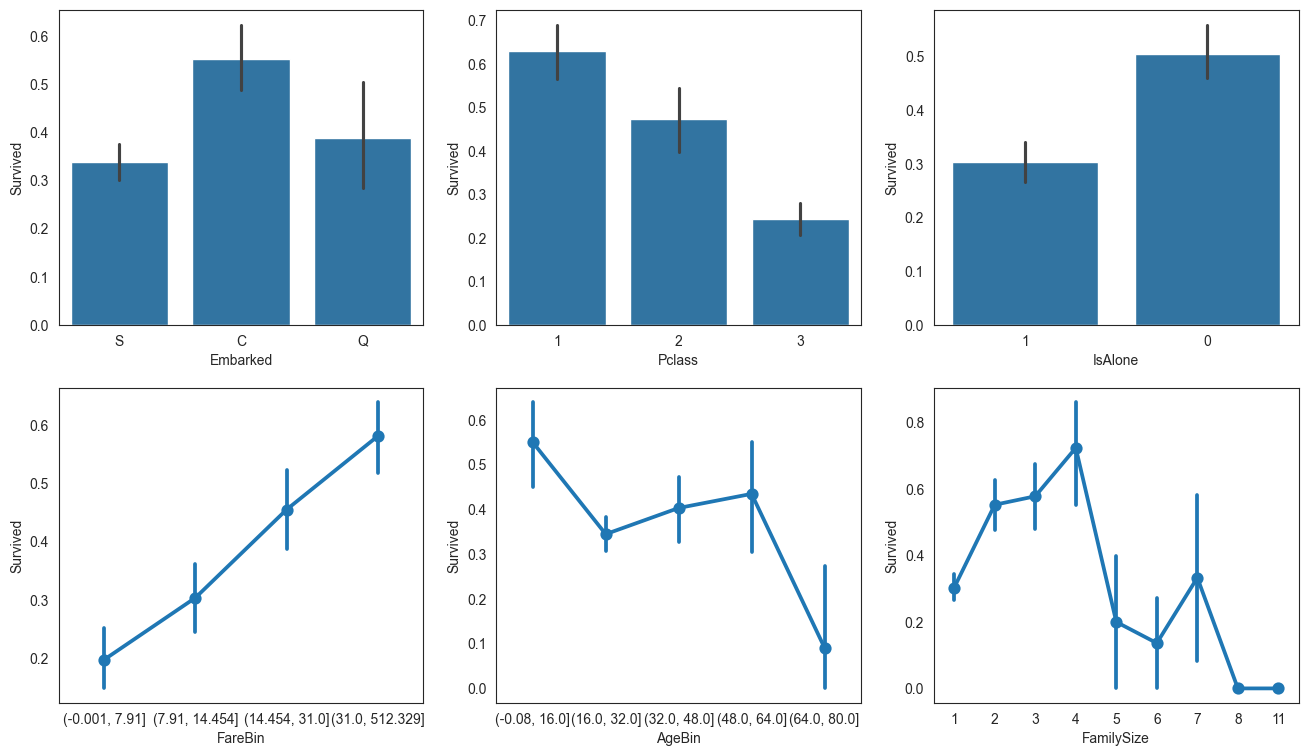

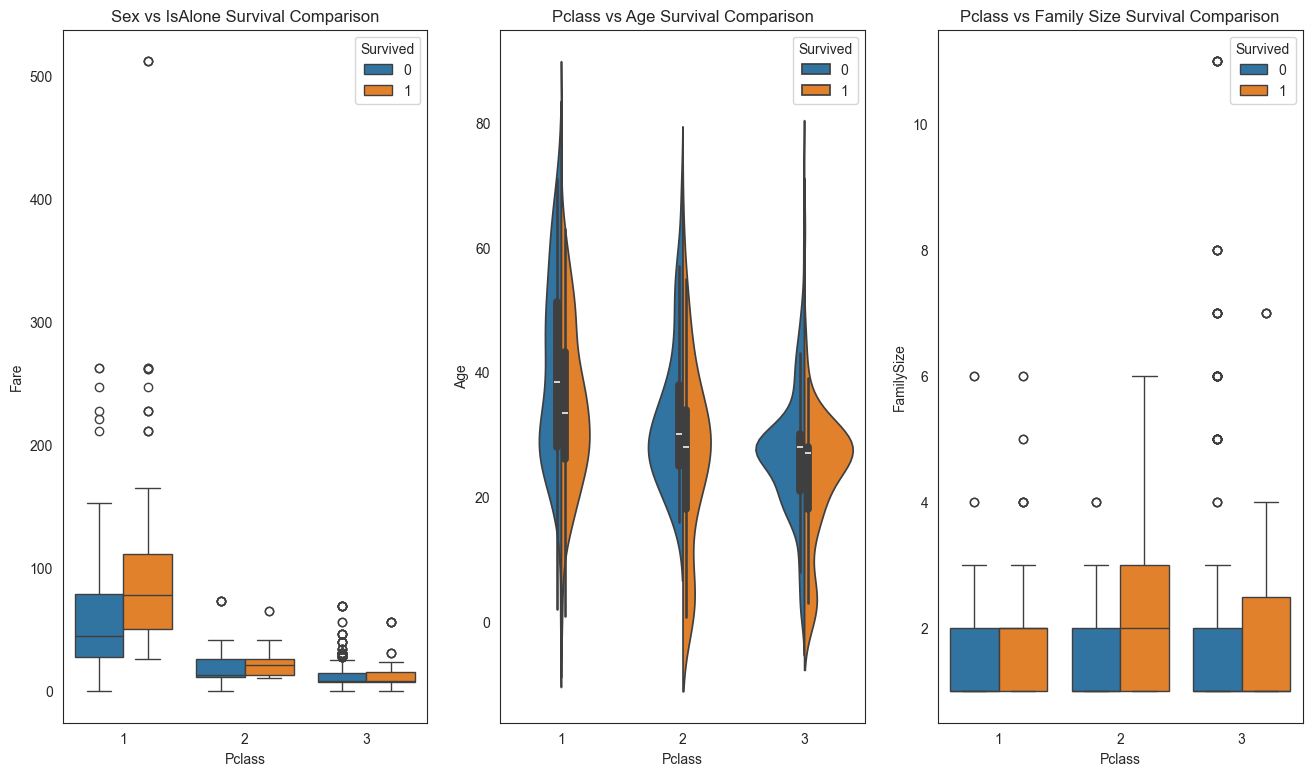

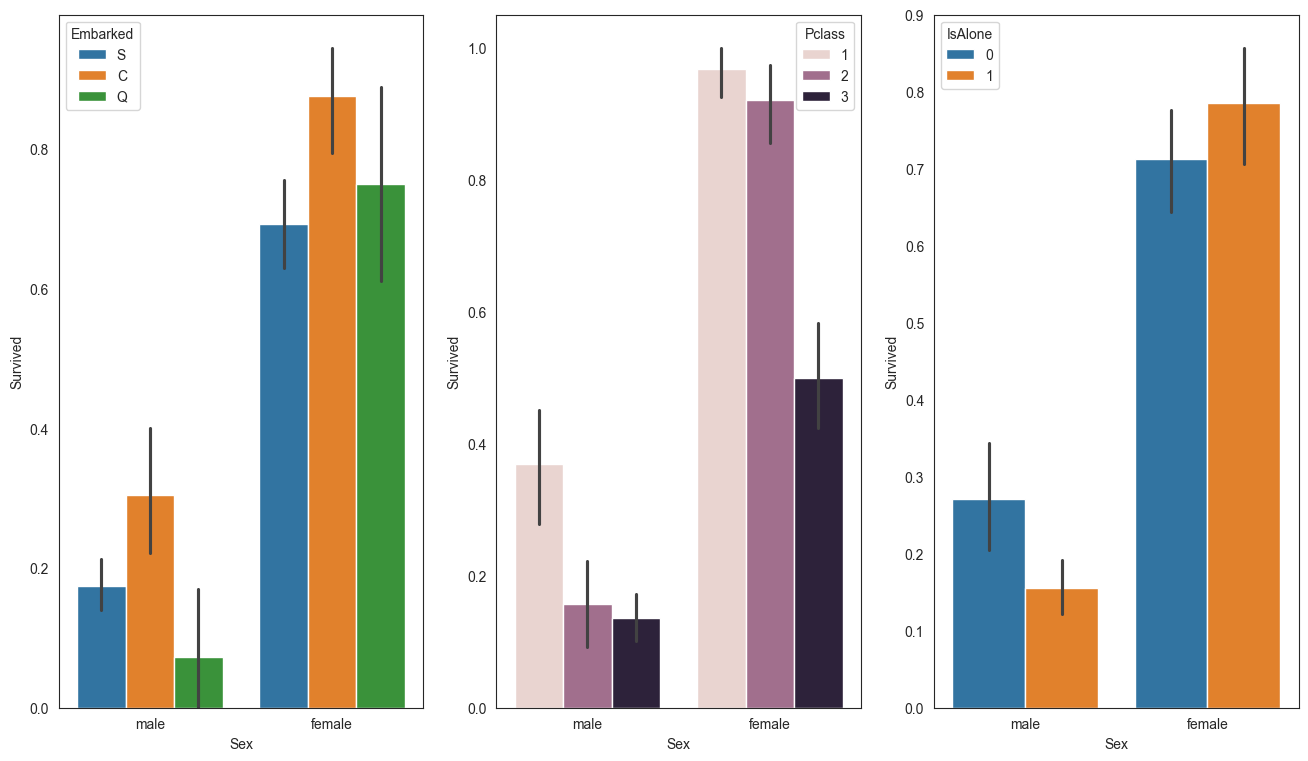

In [8]:

## Data Visualization

fig, saxis = plt.subplots(2, 3,figsize=(16,9))

sns.barplot(x = 'Embarked', y = 'Survived', data=train_data, ax = saxis[0,0])
sns.barplot(x = 'Pclass', y = 'Survived', order=[1,2,3], data=train_data, ax = saxis[0,1])
sns.barplot(x = 'IsAlone', y = 'Survived', order=[1,0], data=train_data, ax = saxis[0,2])

sns.pointplot(x = 'FareBin', y = 'Survived',  data=train_data, ax = saxis[1,0])
sns.pointplot(x = 'AgeBin', y = 'Survived',  data=train_data, ax = saxis[1,1])
sns.pointplot(x = 'FamilySize', y = 'Survived', data=train_data, ax = saxis[1,2])


# graph distribution of qualitative data: Pclass
fig, (axis1,axis2,axis3) = plt.subplots(1,3,figsize=(16,9))

sns.boxplot(x = 'Pclass', y = 'Fare', hue = 'Survived', data = train_data, ax = axis1)
axis1.set_title('Pclass vs Fare Survival Comparison')

sns.violinplot(x = 'Pclass', y = 'Age', hue = 'Survived', data = train_data, split = True, ax = axis2)
axis2.set_title('Pclass vs Age Survival Comparison')

sns.boxplot(x = 'Pclass', y ='FamilySize', hue = 'Survived', data = train_data, ax = axis3)
axis3.set_title('Pclass vs Family Size Survival Comparison')

#graph distribution of qualitative data: Sex
fig, qaxis = plt.subplots(1,3,figsize=(16,9))
sns.barplot(x = 'Sex', y = 'Survived', hue = 'Embarked', data=train_data, ax = qaxis[0])
axis1.set_title('Sex vs Embarked Survival Comparison')

sns.barplot(x = 'Sex', y = 'Survived', hue = 'Pclass', data=train_data, ax  = qaxis[1])
axis1.set_title('Sex vs Pclass Survival Comparison')

sns.barplot(x = 'Sex', y = 'Survived', hue = 'IsAlone', data=train_data, ax  = qaxis[2])
axis1.set_title('Sex vs IsAlone Survival Comparison')


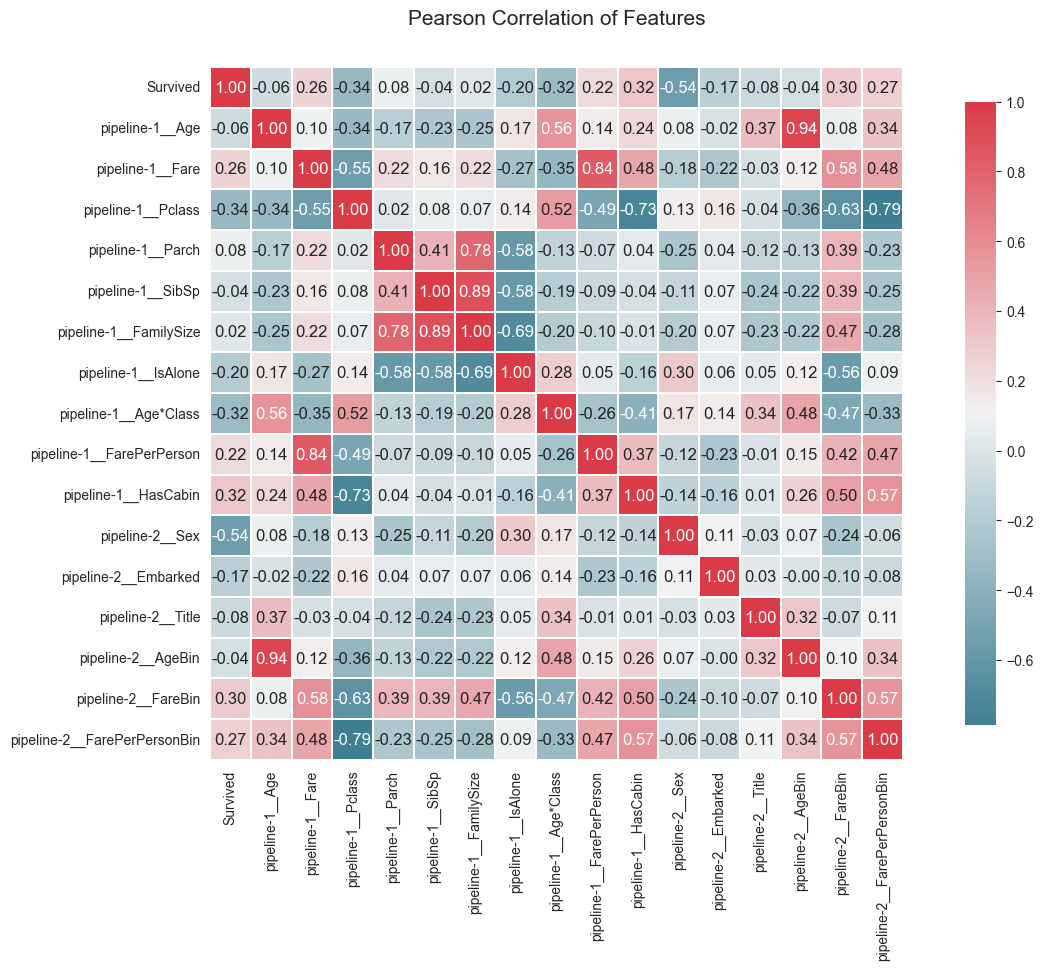

In [9]:

## Correlation Heatmap

def plot_correlation_heatmap(data):
	df = data.copy(deep = True)

	fig, ax = plt.subplots( figsize=(16,9) )
	colormap = sns.diverging_palette(220, 10, as_cmap = True)

	# move suvived column to the first column
	cols = df.columns.tolist()
	cols = cols[-1:] + cols[:-1]
	df = df[cols]

	sns.heatmap(df.corr(),
			 	fmt=".2f",
				cmap = colormap,
				square=True, 
				cbar_kws={'shrink':.9 }, 
				ax=ax,
				annot=True, 
				linewidths=0.1,vmax=1.0, linecolor='white',
				annot_kws={'fontsize':12 }
				)
	
	plt.title('Pearson Correlation of Features', y=1.05, size=15)


plot_correlation_heatmap(train_data_prep)

,MLA Name,MLA Parameters,MLA Train Accuracy Mean,MLA Test Accuracy Mean,MLA Test Accuracy 3*STD,MLA Time
3,GradientBoostingClassifier,"{'ccp_alpha': 0.0, 'criterion': 'friedman_mse'...",0.93,0.84,0.06,0.056684
14,SVC,"{'C': 1.0, 'break_ties': False, 'cache_size': ...",0.85,0.83,0.06,0.018061
0,AdaBoostClassifier,"{'algorithm': 'SAMME.R', 'base_estimator': 'de...",0.86,0.82,0.06,0.030058
4,RandomForestClassifier,"{'bootstrap': True, 'ccp_alpha': 0.0, 'class_w...",0.99,0.82,0.06,0.057713
15,NuSVC,"{'break_ties': False, 'cache_size': 200, 'clas...",0.84,0.82,0.06,0.01971
13,KNeighborsClassifier,"{'algorithm': 'auto', 'leaf_size': 30, 'metric...",0.86,0.82,0.09,0.000744
1,BaggingClassifier,"{'base_estimator': 'deprecated', 'bootstrap': ...",0.97,0.81,0.06,0.012209
2,ExtraTreesClassifier,"{'bootstrap': False, 'ccp_alpha': 0.0, 'class_...",0.99,0.81,0.06,0.04371
5,GaussianProcessClassifier,"{'copy_X_train': True, 'kernel': None, 'max_it...",0.91,0.81,0.06,0.101893
18,LinearDiscriminantAnalysis,"{'covariance_estimator': None, 'n_components':...",0.81,0.8,0.06,0.000772


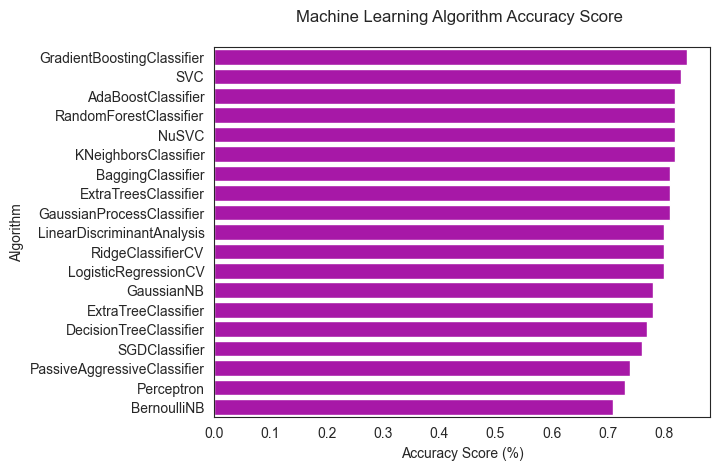

In [10]:
MLA = [
    #Ensemble Methods
    ensemble.AdaBoostClassifier(),
    ensemble.BaggingClassifier(),
    ensemble.ExtraTreesClassifier(),
    ensemble.GradientBoostingClassifier(),
    ensemble.RandomForestClassifier(),

    #Gaussian Processes
    gaussian_process.GaussianProcessClassifier(),
    
    #GLM
    linear_model.LogisticRegressionCV(),
    linear_model.PassiveAggressiveClassifier(),
    linear_model.RidgeClassifierCV(),
    linear_model.SGDClassifier(),
    linear_model.Perceptron(),
    
    #Navies Bayes
    naive_bayes.BernoulliNB(),
    naive_bayes.GaussianNB(),
    
    #Nearest Neighbor
    neighbors.KNeighborsClassifier(),
    
    #SVM
    svm.SVC(probability=True),
    svm.NuSVC(probability=True),
    # svm.LinearSVC(),
    
    #Trees    
    tree.DecisionTreeClassifier(),
    tree.ExtraTreeClassifier(),
    
    #Discriminant Analysis
    discriminant_analysis.LinearDiscriminantAnalysis(),
    # discriminant_analysis.QuadraticDiscriminantAnalysis(),
    ]


from sklearn.model_selection import cross_val_score

MLA_columns = ['MLA Name', 'MLA Parameters','MLA Train Accuracy Mean', 'MLA Test Accuracy Mean', 'MLA Test Accuracy 3*STD' ,'MLA Time']
MLA_compare = pd.DataFrame(columns = MLA_columns)
#create table to compare MLA predictions
MLA_predict = train_data_prep['Survived'].copy(deep = True)

cv_split = model_selection.ShuffleSplit(n_splits = 10, test_size = .3, train_size = .6, random_state = 0 )

row_index = 0
for alg in MLA:
    MLA_name = alg.__class__.__name__
    MLA_compare.loc[row_index, 'MLA Name'] = MLA_name
    MLA_compare.loc[row_index, 'MLA Parameters'] = str(alg.get_params())
    
    cv_results = model_selection.cross_validate(alg, train_data_prep.drop(['Survived'], axis=1), train_data_prep['Survived'], cv  = cv_split, return_train_score=True)

    MLA_compare.loc[row_index, 'MLA Time'] = cv_results['fit_time'].mean()
    MLA_compare.loc[row_index, 'MLA Train Accuracy Mean'] = cv_results['train_score'].mean().round(2)
    MLA_compare.loc[row_index, 'MLA Test Accuracy Mean'] = cv_results['test_score'].mean().round(2)
    MLA_compare.loc[row_index, 'MLA Test Accuracy 3*STD'] = cv_results['test_score'].std().round(2)*3

    #save MLA predictions
    alg.fit(train_data_prep.drop(['Survived'], axis=1), train_data_prep['Survived'])
    MLA_predict[MLA_name] = alg.predict(train_data_prep.drop(['Survived'], axis=1))
    
    row_index+=1

MLA_compare.sort_values(by = ['MLA Test Accuracy Mean'], ascending = False, inplace = True)

sns.barplot(x='MLA Test Accuracy Mean', y = 'MLA Name', data = MLA_compare, color = 'm')
plt.title('Machine Learning Algorithm Accuracy Score \n')
plt.xlabel('Accuracy Score (%)')
plt.ylabel('Algorithm')

MLA_compare

In [11]:

## Hyperparameter Tuning

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

#= RFECV To Select Features =============================
dtree = tree.DecisionTreeClassifier()
dtree_ref = feature_selection.RFECV(dtree, step = 1, scoring = 'accuracy', cv = cv_split)
dtree_ref.fit(train_data_prep.drop(['Survived'], axis=1), train_data_prep['Survived'])

dtree_rfe_features = train_data_prep.drop(['Survived'], axis=1).columns.values[dtree_ref.get_support()]

print('Original features: ', train_data_prep.columns.values)
print('Best features: ', dtree_rfe_features)

print('Decision Tree Classifier accuracy score with all features: ', round(dtree.fit(train_data_prep.drop(['Survived'], axis=1), train_data_prep['Survived']).score(train_data_prep.drop(['Survived'], axis=1), train_data_prep['Survived'])*100, 2).astype(str)+'%')
print('Decision Tree Classifier accuracy score with selected features: ', round(dtree.fit(train_data_prep[dtree_rfe_features], train_data_prep['Survived']).score(train_data_prep[dtree_rfe_features], train_data_prep['Survived'])*100, 2).astype(str)+'%')

#= Hyperparameter Tuning =============================
param_grid = {
	          # 'criterion': ['gini', 'entropy'],  #scoring methodology; two supported formulas for calculating information gain - default is gini
              'splitter': ['best', 'random'], #splitting methodology; two supported strategies - default is best
              'max_depth': [2,4,6,8,10,12,None], #max depth tree can grow; default is none
              # 'min_samples_split': [2,5,10,.03,.05], #minimum subset size BEFORE new split (fraction is % of total); default is 2
              'min_samples_leaf': [1,5,10,.03,.05], #minimum subset size AFTER new split split (fraction is % of total); default is 1
              # 'max_features': [None, 'auto'], #max features to consider when performing split; default none or all
			  
              'class_weight': ['balanced', None], #default None; can pass a dictionary of each class weight; balanced automatically adjusts weights inversely proportional to class frequencies
              # 'random_state': [0] #seed or control random number generator: https://www.quora.com/What-is-seed-in-random-number-generation
             }

dtree_rfe_tuned = GridSearchCV(dtree, param_grid=param_grid, cv = cv_split, return_train_score=True, scoring = 'roc_auc')
# dtree_rfe_tuned.fit(train_data_prep[dtree_rfe_features], train_data_prep['Survived'])
dtree_rfe_tuned.fit(train_data_prep.drop(['Survived'], axis=1), train_data_prep['Survived'])

print('Best parameters: ', dtree_rfe_tuned.best_params_)
print('Best score: ', dtree_rfe_tuned.best_score_.round(3))
print('Best Train score: ', dtree_rfe_tuned.cv_results_['mean_train_score'][dtree_rfe_tuned.best_index_].round(3))

Original features:  ['pipeline-1__Age' 'pipeline-1__Fare' 'pipeline-1__Pclass'
 'pipeline-1__Parch' 'pipeline-1__SibSp' 'pipeline-1__FamilySize'
 'pipeline-1__IsAlone' 'pipeline-1__Age*Class' 'pipeline-1__FarePerPerson'
 'pipeline-1__HasCabin' 'pipeline-2__Sex' 'pipeline-2__Embarked'
 'pipeline-2__Title' 'pipeline-2__AgeBin' 'pipeline-2__FareBin'
 'pipeline-2__FarePerPersonBin' 'Survived']
Best features:  ['pipeline-1__Age' 'pipeline-1__Fare' 'pipeline-1__Pclass'
 'pipeline-1__Parch' 'pipeline-1__SibSp' 'pipeline-1__FamilySize'
 'pipeline-1__Age*Class' 'pipeline-1__FarePerPerson'
 'pipeline-1__HasCabin' 'pipeline-2__Sex' 'pipeline-2__Embarked'
 'pipeline-2__Title' 'pipeline-2__AgeBin' 'pipeline-2__FareBin'
 'pipeline-2__FarePerPersonBin']
Decision Tree Classifier accuracy score with all features:  98.43%
Decision Tree Classifier accuracy score with selected features:  98.43%
Best parameters:  {'class_weight': None, 'max_depth': None, 'min_samples_leaf': 0.03, 'splitter': 'best'}
Best s

In [12]:
## Voting Classifier

vote_est_hard = [
	#Ensemble Methods
	('ada', ensemble.AdaBoostClassifier()),
    ('bc', ensemble.BaggingClassifier()),
    # ('etc', ensemble.ExtraTreesClassifier()),
    ('gbc', ensemble.GradientBoostingClassifier()),
    ('rfc', ensemble.RandomForestClassifier()),
	
    #Gaussian Processes
    # ('gpc', gaussian_process.GaussianProcessClassifier()),
	
    #GLM
    ('lr', linear_model.LogisticRegressionCV()),
    ('pac', linear_model.PassiveAggressiveClassifier()),
    ('rc', linear_model.RidgeClassifierCV()),
    ('sgdc', linear_model.SGDClassifier()),
    ('pc', linear_model.Perceptron()),
	
    #Navies Bayes
    ('bnb', naive_bayes.BernoulliNB()),
    ('gnb', naive_bayes.GaussianNB()),
	
    #Nearest Neighbor
    ('knn', neighbors.KNeighborsClassifier()),
	
    #SVM
    ('svc', svm.SVC(probability=True)),
    ('nusvc', svm.NuSVC(probability=True)),
	
    #Trees
    ('dtc', tree.DecisionTreeClassifier()),
    # ('etc', tree.ExtraTreeClassifier()),
	
    #Discriminant Analysis
    ('lda', discriminant_analysis.LinearDiscriminantAnalysis()),
    # ('qda', discriminant_analysis.QuadraticDiscriminantAnalysis()),
]

vote_est_soft = [
	#Ensemble Methods
	('ada', ensemble.AdaBoostClassifier()),
    ('bc', ensemble.BaggingClassifier()),
    ('etc', ensemble.ExtraTreesClassifier()),
    ('gbc', ensemble.GradientBoostingClassifier()),
    ('rfc', ensemble.RandomForestClassifier()),
	
    #GLM
    ('lr', linear_model.LogisticRegressionCV()),
	
    ('knn', neighbors.KNeighborsClassifier()),

    #SVM
    ('svc', svm.SVC(probability=True)),
    # ('nusvc', svm.NuSVC(probability=True)),
	
    #Neural network
    # ('mlp', MLPClassifier( max_iter=2000)),
]

#= RFECV To Select Features =============================

grid_hard = ensemble.VotingClassifier(estimators = vote_est_hard , 
									  voting = 'hard')
grid_soft = ensemble.VotingClassifier(estimators = vote_est_soft ,
									  voting = 'soft')

grid_hard_cv = model_selection.cross_validate(grid_hard, train_data_prep.drop(['Survived'], axis=1), train_data_prep['Survived'], cv  = cv_split, return_train_score=True)
grid_soft_cv = model_selection.cross_validate(grid_soft, train_data_prep.drop(['Survived'], axis=1), train_data_prep['Survived'], cv  = cv_split, return_train_score=True)
# grid_hard.fit(train_data_prep.drop(['Survived'], axis=1), train_data_prep['Survived'])


print("Hard Voting w/Tuned Hyperparameters Training w/bin score mean: {:.2f}". format(grid_hard_cv['train_score'].mean()*100))
print("Hard Voting w/Tuned Hyperparameters Test w/bin score mean: {:.2f}". format(grid_hard_cv['test_score'].mean()*100))
print("Hard Voting w/Tuned Hyperparameters Test w/bin score 3*std: {:.2f}". format(grid_hard_cv['test_score'].std()*100*3))
print('-'*10)
print("Soft Voting w/Tuned Hyperparameters Training w/bin score mean: {:.2f}". format(grid_soft_cv['train_score'].mean()*100))
print("Soft Voting w/Tuned Hyperparameters Test w/bin score mean: {:.2f}". format(grid_soft_cv['test_score'].mean()*100))
print("Soft Voting w/Tuned Hyperparameters Test w/bin score 3*std: {:.2f}". format(grid_soft_cv['test_score'].std()*100*3))
print('-'*10)


Hard Voting w/Tuned Hyperparameters Training w/bin score mean: 88.41
Hard Voting w/Tuned Hyperparameters Test w/bin score mean: 83.10
Hard Voting w/Tuned Hyperparameters Test w/bin score 3*std: 7.20
----------
Soft Voting w/Tuned Hyperparameters Training w/bin score mean: 94.70
Soft Voting w/Tuned Hyperparameters Test w/bin score mean: 83.84
Soft Voting w/Tuned Hyperparameters Test w/bin score 3*std: 7.48
----------


In [13]:

## Final Prediction

model_final = grid_soft.fit(train_data_prep.drop(['Survived'], axis=1), train_data_prep['Survived'])
# model_final = dtree_rfe_tuned.fit(train_data_prep.drop(['Survived'], axis=1), train_data_prep['Survived'])

Y_test_pred = model_final.predict(test_data_prep)
output = pd.DataFrame({'PassengerId': test_data.PassengerId, 'Survived': Y_test_pred})
print(output.head())
output.to_csv('submission.csv', index=False)


   PassengerId  Survived
0          892         0
1          893         0
2          894         0
3          895         0
4          896         1


In [14]:

# ## Preprocessing TESTING ###############################################################
# ################################################################################
# X_train = train_data_raw.copy(deep=True)
# Y_train = train_data_raw['Survived'].copy(deep=True)
# X_train_cat = X_train.select_dtypes(include=[object])
# X_train_num = X_train.select_dtypes(include=[np.number])
# X_test = test_data.copy(deep=True)
# female = train_data_raw[train_data_raw['Sex']=='female']
# male   = train_data_raw[train_data_raw['Sex']=='male']

# print(X_train)
# #
# female_Survived = female['Survived']
# male_Survived = male['Survived']
# # print(sum(female_Survived)/len(female_Survived))
# # print(sum(male_Survived)/len(male_Survived))

# #= Adding new features =========================================================
# def get_bin_index(x, bins):
# 	return np.digitize(x, bins=bins)

# def add_new_features(df, print_survived=False):
# 	#* AgeBin
# 	age_bin = [0, 10, 18, 40, 60, np.inf]
# 	fair_bin = [0, 20, 40, 60, np.inf]
# 	fair_per_person_bin = [0, 20, 40, 60, 80, np.inf]
# 	df['AgeBin'] = df['Age'].apply(lambda x: get_bin_index(x, bins=age_bin))
# 	df['FareBin'] = df['Fare'].apply(lambda x: get_bin_index(x, bins=fair_bin))
# 	#* FamilySize
# 	df['FamilySize'] = df['SibSp'] + df['Parch'] + 1
# 	#* IsAlone
# 	df['IsAlone'] = 0
# 	df.loc[df['FamilySize']==1, 'IsAlone'] = 1
# 	#* Age*Class
# 	df['Age*Class'] = df['AgeBin'] * df['Pclass']
# 	#* Title
# 	df['Title'] = df['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)
# 	df['Title'] = df['Title'].replace(['Lady', 'Countess','Capt', 'Col',\
# 		'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
# 	df['Title'] = df['Title'].replace('Mlle', 'Miss')
# 	df['Title'] = df['Title'].replace('Ms', 'Miss')
# 	df['Title'] = df['Title'].replace('Mme', 'Mrs')
# 	#* Cabin
# 	# df['HasCabin'] = df['Cabin'].apply(lambda x: 0 if pd.isnull(x) else 1)
# 	#* Fare per person
# 	df['FarePerPerson'] = df['Fare'] / df['FamilySize']
# 	#* Fare per person bin
# 	df['FarePerPersonBin'] = df['FarePerPerson'].apply(lambda x: get_bin_index(x, bins=fair_per_person_bin))


# 	if print_survived:
# 		print(df[['AgeBin', 'Survived']].groupby(['AgeBin'], observed=True).mean().sort_values(by='Survived', ascending=False))
# 		print(df[['FareBin', 'Survived']].groupby(['FareBin'], observed=True).mean().sort_values(by='Survived', ascending=False))
# 		print(df[['FamilySize', 'Survived']].groupby(['FamilySize'], observed=True).mean().sort_values(by='Survived', ascending=False))
# 		print(df[['IsAlone', 'Survived']].groupby(['IsAlone'], observed=True).mean().sort_values(by='Survived', ascending=False))
# 		print(df[['Age*Class', 'Survived']].groupby(['Age*Class'], observed=True).mean().sort_values(by='Survived', ascending=False))
# 		print(df[['Title', 'Survived']].groupby(['Title'], observed=True).mean().sort_values(by='Survived', ascending=False))
# 		# print(df[['HasCabin', 'Survived']].groupby(['HasCabin'], observed=True).mean().sort_values(by='Survived', ascending=False))
# 		print(df[['FarePerPersonBin', 'Survived']].groupby(['FarePerPersonBin'], observed=True).mean().sort_values(by='Survived', ascending=False))


# add_new_features(X_train, True)
# add_new_features(X_test)

# #= Label Encoding =============================================================
# from sklearn.preprocessing import FunctionTransformer

# # Define the function that will be used for the transformation
# def map_string(s):
#     return np.where(pd.isnull(s), 0, 1)


# # Create the transformer
# cat_binary_transformer = FunctionTransformer(map_string, feature_names_out='one-to-one')


# #= One Hot Encoding ===========================================================
# from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
# # cat_encoder = OneHotEncoder(handle_unknown='ignore')
# # X_train_cat_prep = cat_encoder.fit_transform(X_train_cat).toarray()
# # X_train_cat_prep = pd.DataFrame(X_train_cat_prep, columns=cat_encoder.get_feature_names_out())
# # print(X_train_cat_prep.head())

# #= Replace the missing value with median =======================================
# from sklearn.impute import SimpleImputer
# # imputer = SimpleImputer(strategy="median")
# # X_train_num_prep = imputer.fit_transform(X_train_num)
# # X_train_num_prep = pd.DataFrame(X_train_num_prep, columns=imputer.get_feature_names_out())
# # print(X_train_num_prep.head())

# #= Combine the two =============================================================
# # X_train_prep = pd.concat([X_train_cat_prep, X_train_num_prep], axis=1)
# # print(X_train_prep.head())


# #= Pipeline ====================================================================
# from sklearn.pipeline import make_pipeline
# from sklearn.compose import make_column_transformer, make_column_selector
# from sklearn.preprocessing import StandardScaler, MinMaxScaler
# from sklearn.preprocessing import KBinsDiscretizer, LabelEncoder

# num_pipeline = make_pipeline(SimpleImputer(strategy="median"),
#                              StandardScaler(),
# 							#  MinMaxScaler(),
#                     		)
# num_pipeline_bin = make_pipeline(
# 								# SimpleImputer(strategy="median"),
# 							 	OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1 ),
#                                 StandardScaler(),
# 								# MinMaxScaler(),
# 							 )

# # cat_pipeline = make_pipeline(OneHotEncoder(handle_unknown='ignore'))
# cat_pipeline = make_pipeline(SimpleImputer(strategy="most_frequent"),
#                              OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1 ),
# 							 StandardScaler(),
# 							 )
# cat_binary_pipeline = make_pipeline(cat_binary_transformer)

# # bucketing cabin into HasCabin and NoCabin
# # from sklearn.preprocessing import KBinsDiscretizer
# # cat_pipeline = make_pipeline(OneHotEncoder(handle_unknown='ignore'),
# # 							 KBinsDiscretizer(n_bins=2, encode='onehot-dense'))

# # X_train_num_prep = num_pipeline.fit_transform(X_train_num)

# # X_train_num_prep = num_pipeline.fit_transform(X_train)
# # X_train_num_prep = pd.DataFrame(X_train_num_prep, columns=num_pipeline.get_feature_names_out())
# # X_train_cat_prep = cat_pipeline.fit_transform(X_train).toarray()
# # X_train_cat_prep = pd.DataFrame(X_train_cat_prep, columns=cat_pipeline.get_feature_names_out())
# # X_train_num_prep.head()
# # X_train_cat_prep.head()

# #* Manually select the columns
# preprocess_pipeline = make_column_transformer(
# 	(num_pipeline, ['Age', 'Fare', 'Pclass', 'Parch', 'SibSp', 
# 				 'FamilySize', 'IsAlone', 'Age*Class', 'HasCabin']),
# 	(num_pipeline_bin, ['AgeBin', 'FareBin', 'FarePerPersonBin']),
# 	(cat_pipeline, ['Sex', 'Embarked', 'Title']),
# 	# (cat_binary_pipeline, ['Cabin'])
# )

# #* Automatically select the columns
# # preprocess_pipeline = make_column_transformer(
# # 	(num_pipeline, make_column_selector(dtype_include=np.number)),
# # 	(cat_pipeline, make_column_selector(dtype_include=object))
# # )

# X_train_prep = preprocess_pipeline.fit_transform(X_train)
# X_train_prep = pd.DataFrame(X_train_prep, columns=preprocess_pipeline.get_feature_names_out())
# X_train_prep.head(10)

In [15]:

# from sklearn.model_selection import cross_val_score
# from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, VotingClassifier, StackingClassifier, BaggingClassifier
# from sklearn.linear_model import LogisticRegression, SGDClassifier, RidgeClassifier, Perceptron
# from sklearn.svm import SVC
# from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
# from sklearn.neighbors import KNeighborsClassifier, RadiusNeighborsClassifier
# from sklearn.metrics import accuracy_score 


# #print correlation
# # corr_matrix = train_data.corr()

# rf = RandomForestClassifier(n_estimators=100)
# vote = VotingClassifier(estimators=[
# 									('lr', LogisticRegression()), 
# 									('sgd', SGDClassifier()),
# 									('svc', SVC()),
# 									('knn', KNeighborsClassifier(n_neighbors = 3)),
# 									('dt', DecisionTreeClassifier()),
# 									('rf', RandomForestClassifier(n_estimators=100)),
# 									('ada', AdaBoostClassifier()),
# 									('gb', GradientBoostingClassifier()),
# 									('bag', BaggingClassifier()),
# 									], 
# 									voting='hard')

# print('Random Forest	', sum(cross_val_score(rf, X_train_prep, Y_train, cv=3, scoring="accuracy"))/3)
# print('Voting	', sum(cross_val_score(vote, X_train_prep, Y_train, cv=3, scoring="accuracy"))/3)
# print('SVC	', sum(cross_val_score(SVC(), X_train_prep, Y_train, cv=3, scoring="accuracy"))/3)
# print('KNN	', sum(cross_val_score(KNeighborsClassifier(n_neighbors = 3), X_train_prep, Y_train, cv=3, scoring="accuracy"))/3)
# print('Decision Tree	', sum(cross_val_score(DecisionTreeClassifier(), X_train_prep, Y_train, cv=3, scoring="accuracy"))/3)
# print('AdaBoost	', sum(cross_val_score(AdaBoostClassifier(), X_train_prep, Y_train, cv=3, scoring="accuracy"))/3)
# print('Gradient Boosting	', sum(cross_val_score(GradientBoostingClassifier(), X_train_prep, Y_train, cv=3, scoring="accuracy"))/3)
# model = vote
# model.fit(X_train_prep, Y_train)
# print(model.score(X_train_prep, Y_train))

# X_test_prep = preprocess_pipeline.transform(X_test)
# X_test_prep = pd.DataFrame(X_test_prep, columns=preprocess_pipeline.get_feature_names_out())
# # print(X_test_prep.head())

# Y_test_pred = model.predict(X_test_prep)
# output = pd.DataFrame({'PassengerId': test_data.PassengerId, 'Survived': Y_test_pred})
# print(output.head())
# output.to_csv('submission.csv', index=False)